# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Isotropic metrics

In this notebook, we solve isotropic eikonal equations on the CPU and the GPU, and  and check that they produce consistent results.

We obtain substantial accelerations on sufficiently large instances, a few million points, by a factor up to $100$. Note that smaller test cases yield less acceleration, due to the difficulty to extract parallelism.

**bit-consistency** By design, the CPU and GPU codes produce the same values, up to machine precision, which is approximately $10^{-8}$ for floating point types, in a variety on situations. 
This is due to the fact that the two implementations, although widely different, solve the same discretized problem. We try to ensure this behavior and check it as much as possible, as it is a strong indicator of the validity of the implementations. We refer to it as bit-consistency, aknowledging that it is a bit abusive, since the algorithm outputs, while extremely close, are still far from a bit-for-bit match.

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1 Three dimensions](#1-Three-dimensions)
  * [2 Two dimensions](#2-Two-dimensions)
  * [3. GPU specific options](#3.-GPU-specific-options)
    * [3.1 Multiprecision](#3.1-Multiprecision)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [4]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [28]:
import cupy as cp
import numpy as np
#import time
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [6]:
from agd import HFMUtils
#from agd.HFMUtils import HFM_CUDA
from agd import AutomaticDifferentiation as ad
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
from agd.HFMUtils import RunGPU,RunSmart

In [7]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

### 0.1 Decorations for gpu usage

Dealing with GPU data induces minor inconveniences:
- GPU arrays are not implicitly convertible to CPU arrays, and this is a good thing since memory transfers from GPU memory to CPU memory, and conversely, are not cheap. The `get` method must be applied to a cupy array to retrieve a numpy array.
- GPU computing is much more efficient with 32 bit data types, integer and floating point, than with their 64bit counterparts. However a number of numpy and cupy basic functions default to 64bit output, which will be inconsistent with the rest of computations.

We provide decorators to perform these memory transfers and data type conversions automatically. They are only applied to specific modules and functions, below, to avoid excessive implicit operations. 

In [41]:
cp = cugen.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = cugen.decorate_module_functions(plt,cugen.cupy_get_args)
RunSmart = cugen.cupy_get_args(RunSmart,dtype64=True,iterables=(dict,))

Casting output of function linspace from float64 to float32


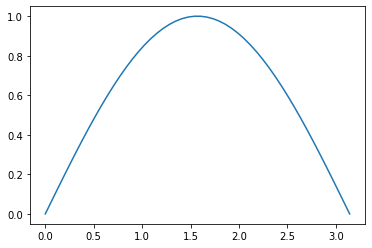

In [9]:
X = cp.linspace(0,np.pi) # 64 bit output is converted to 32 bit by decorator
plt.plot(X,np.sin(X));   # GPU array is transfered to CPU memory.

Note that, by default, these decorators do not apply to the system module, by only to a shallow copy.

In [10]:
sys.modules['cupy'].linspace(0,np.pi).dtype

dtype('float64')

### 0.2 Utility functions

In [11]:
def RunCompare(gpuIn,check=True):
    gpuOut = RunGPU(gpuIn)
    if gpuIn.get('verbosity',1): print("---")
    cpuOut = RunSmart(gpuIn)
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
    cpuTime = cpuOut['FMCPUTime']; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    assert not check or cp.allclose(gpuOut['values'],cpuOut['values'],atol=1e-6)
    return gpuOut,cpuOut

## 1 Three dimensions

GPU acceleration shines particularly well in three dimensions, where we get accelerations by a factor $100$ on common sizes.

In [99]:
n = 200 # Typical instance size
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic3',
    'seeds':[[0.,0.5,1.]],
    'exportValues':1,
    'cost':cp.array(1.),
})
hfmIn.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [18]:
RunCompare(hfmIn);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.10149693489074707 seconds, in 127 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 11.334 s.
Max |gpuValues-cpuValues| :  7.748603827462119e-07
Solver time (s). GPU : 0.10149693489074707, CPU : 11.334. Device acceleration : 111.66839680626907


We check bit-consistency for a few variants of the scheme.

In [100]:
n=50; hfmInS = hfmIn.copy() # Define the a smaller instance
hfmInS.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'cost': np.prod(np.sin(2*np.pi*X)) + 1.1, # Non-constant cost
    'verbosity':0,
})

In [98]:
factor_variants = [
    {}, # Default
    {"seedRadius":2}, # Spread seed information
    {"factorizationRadius":10,'factorizationPointChoice':'Key'} # Source factorization
]
multip_variants = [
    {'multiprecision':False}, # Default
    {'multiprecision':True}, # Reduces roundoff errors
]
order_variants = [
    {'order':1}, # Default
    {'order':2}, # More accurate on smooth instances
]

In [53]:
for fact,multip in itertools.product(factor_variants,multip_variants):
    print(f"\nReproducibility with options : {fact}, {multip}")
    RunCompare({**hfmInS,**fact,**multip})


Reproducibility with options : {}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  4.64916229736545e-07
Solver time (s). GPU : 0.01947784423828125, CPU : 0.104. Device acceleration : 5.339399921660791

Reproducibility with options : {}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.1071957062291915e-07
Solver time (s). GPU : 0.015997648239135742, CPU : 0.107. Device acceleration : 6.688483107050776

Reproducibility with options : {'seedRadius': 2}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  4.64916229736545e-07
Solver time (s). GPU : 0.019005775451660156, CPU : 0.106. Device acceleration : 5.577252044758894

Reproducibility with options : {'seedRadius': 2}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.0536437211605687e-07
Solver time (s). GPU : 0.01949930191040039, CPU : 0.107. Device acceleration : 5.487375932311154

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}, {'multiprecision': False}
Max |gpu

The second order scheme implementation has some slight differences between the GPU and CPU implementation, hence *one cannot expect bit-consistency in general*. Still, it may happen sometimes, especially when the seed is in a corner.

In [101]:
hfmInS.update({
    'seeds':[[0.0,0.,1.]],
    'order':2,
})

In [102]:
for fact,multip in itertools.product((factor_variants[0],factor_variants[2]),multip_variants):
    print(f"\nReproducibility with options : {fact}, {multip}")
    RunCompare({**hfmInS,**fact,**multip},check=False)


Reproducibility with options : {}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  6.33969647223509e-07
Solver time (s). GPU : 0.022993803024291992, CPU : 0.155. Device acceleration : 6.740946673164459

Reproducibility with options : {}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.1708051816938791e-07
Solver time (s). GPU : 0.024487733840942383, CPU : 0.161. Device acceleration : 6.574720267941466

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  6.33969647223509e-07
Solver time (s). GPU : 0.02350139617919922, CPU : 0.153. Device acceleration : 6.51025151158544

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.1708051816938791e-07
Solver time (s). GPU : 0.02498459815979004, CPU : 0.161. Device acceleration : 6.443969959825561


## 2 Two dimensions

In two dimensions, it is usually more difficult to extract parallism than in three dimensions.
Indeed, the front propagated in the computations is expected to have approximately
$$
    N^{\frac{d-1} d}
$$
points in dimension $d$, where $N$ denotes the total number of points in the domain. 
The front in a two dimensional computation thus has $N^{\frac 1 2}$ points which is much fewer than $N^{\frac 2 3}$ in three dimensions, when $N$ is large. In addition the number of points $N$ is also often fewer in two dimensional problems.

In [181]:
n=4000
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.5]],
    'exportValues':1,
    'cost':cp.array(1.),
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [91]:
_,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.2864964008331299 seconds, in 251 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 10.211 s.
Max |gpuValues-cpuValues| :  7.016089529832126e-05
Solver time (s). GPU : 0.2864964008331299, CPU : 10.211. Device acceleration : 35.640936396780106


Another annoyance is that the numerical error, close to $10^{-4}$, is not as good as could be expected, around $10^{-7}$ for single precision floating point types. 
A quick fix, explained in more detail below and which does have a computational cost, is to run the computation using multiprecision.

In [92]:
gpuOut = RunGPU({**hfmIn,'multiprecision':True})
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.436981201171875 seconds, in 251 iterations.
Post-Processing
Max |gpuValues-cpuValues| :  1.2125012438524152e-07


In [140]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'cost':np.prod(np.sin(2*np.pi*X)) +1.1, # Non-constant cost
    'verbosity':0,
})

In [97]:
for fact,multip in itertools.product(factor_variants,multip_variants):
    print(f"\nReproducibility with options : {fact}, {multip}")
    RunCompare({**hfmInS,**fact,**multip})


Reproducibility with options : {}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  1.258254053060348e-06
Solver time (s). GPU : 0.008501052856445312, CPU : 0.016. Device acceleration : 1.882119811532421

Reproducibility with options : {}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  9.828872182815473e-08
Solver time (s). GPU : 0.00999903678894043, CPU : 0.015. Device acceleration : 1.5001444955769092

Reproducibility with options : {'seedRadius': 2}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  1.258254053060348e-06
Solver time (s). GPU : 0.008496522903442383, CPU : 0.015. Device acceleration : 1.7654280663355502

Reproducibility with options : {'seedRadius': 2}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.107493061702769e-07
Solver time (s). GPU : 0.00999140739440918, CPU : 0.015. Device acceleration : 1.501289999284129

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}, {'multiprecision': False}
Max |g

Again, bit consistency is not expected with the second order scheme, but not excluded either.

In [141]:
hfmInS.update({
    'seeds':[[0.0,1.]],
    'order':2,
})

In [111]:
for fact,multip in itertools.product((factor_variants[0],factor_variants[2]),multip_variants):
    print(f"\nReproducibility with options : {fact}, {multip}")
    RunCompare({**hfmInS,**fact,**multip},check=False)


Reproducibility with options : {}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  4.887580871582031e-06
Solver time (s). GPU : 0.015999794006347656, CPU : 0.025. Device acceleration : 1.5625201168266079

Reproducibility with options : {}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.147018509062292e-07
Solver time (s). GPU : 0.016997814178466797, CPU : 0.025. Device acceleration : 1.4707773445170702

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}, {'multiprecision': False}
Max |gpuValues-cpuValues| :  4.887580871582031e-06
Solver time (s). GPU : 0.012996435165405273, CPU : 0.026. Device acceleration : 2.000548586523821

Reproducibility with options : {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'}, {'multiprecision': True}
Max |gpuValues-cpuValues| :  1.147018509062292e-07
Solver time (s). GPU : 0.016505956649780273, CPU : 0.024. Device acceleration : 1.4540205399315336


## 3. GPU specific options



### 3.1 Multiprecision

In multi-precision mode, the front values are represented as pairs 
$$
    u(x) = u_q(x) \delta + u_r(x),
$$
where $u_q(x) \in Z$ is an integer, $\delta>0$ is a fixed scale, and $u_r(x) \in [-\delta/2,\delta/2[$.

The parameter $\delta$ is set automatically as the largest power of two (usually a negative power) bounded by $h/10$, where $h$ is the grid scale. The choice of a power of two avoids roundoff errors.

Eventually, the result is converted to floating point format. A slightly better accuracy can be obtained by using a double type in this last step.

In [182]:
gpuOut = RunGPU({**hfmIn,'values_float64':True})
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
Setup and run the eikonal solver
GPU solve took 0.4584968090057373 seconds, in 251 iterations.
Post-Processing
Max |gpuValues-cpuValues| :  6.194407586868067e-08


### 3.2 Block shape

The GPU implementation of the fast marching method works by grouping together blocks of grid points, which are updated simultaneously a prescribed number of times. The shape of these blocks ` shape_i`  and number of iterations `niter_i` can be modified, which may affect performance. They are collected in the `traits` input parameter, together with a number of compile time constants and typedefs for the GPU kernel.

In [184]:
gpuOut['keys']['defaulted']['traits']

{'Scalar': numpy.float32,
 'Int': numpy.int32,
 'multiprecision_macro': 1,
 'pruning_macro': 0,
 'shape_i': (24, 24),
 'niter_i': 48,
 'strict_iter_o_macro': 1,
 'strict_iter_i_macro': 1,
 'ndim_macro': 2}

### 3.3 Periodicity

In [224]:
ReloadPackages()

In [234]:
n=48
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.2,0.4]],
    'exportValues':1,
    'cost':cp.array(1.),
    'verbosity':1,
    'periodic':(False,True)
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [235]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)
Preparing the GPU kernel
#define Scalar_macro
typedef float Scalar;
#define Int_macro
typedef int Int;
#define multiprecision_macro 0
#define pruning_macro 0
#define shape_i_macro
const int shape_i[2] = {24,24};
#define niter_i_macro
const int niter_i=48;
#define ndim_macro 2
#define periodic_macro 1
#define periodic_axes_macro
const int periodic_axes[2] = {false,true};
const Int Int_MAX = 2147483647;
const int size_i = 576;
const int log2_size_i = 10;

Setup and run the eikonal solver
GPU solve took 0.005472421646118164 seconds, in 7 iterations.
Post-Processing


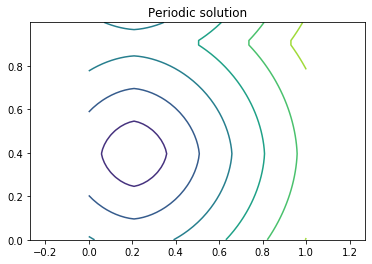

In [236]:
X = hfmIn.Grid()
plt.title('Periodic solution'); plt.axis('equal')
plt.contour(*X,gpuOut['values']); 

### 3.4 Help and parameter defaults

The HFM algorithm sets a number of parameters to (hopefull relevant) default values. 
Setting a verbosity equal or larger than two will display some of the associated values.

In [174]:
n=200
hfmIn = HFMUtils.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.5]],
    'exportValues':1,
    'cost':cp.array(1.),
    'verbosity':2
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

Casting output of function array from float64 to float32


In [175]:
gpuOut = RunGPU(hfmIn)

key help defaults to []
Setting the kernel traits.
(Scalar,Int,shape_i,niter_i,...)
key traits defaults to {'Scalar': <class 'numpy.float32'>, 'Int': <class 'numpy.int32'>, 'multiprecision_macro': 0, 'pruning_macro': 0, 'shape_i': (24, 24), 'niter_i': 48}
key multiprecision defaults to False
key values_float64 defaults to False
key factoringRadius defaults to 0
key order defaults to 1
Prepating the domain data (shape,metric,...)
key periodic defaults to (False, False)
key overwriteMetric defaults to False
Preparing the values array (setting seeds,...)
key seedValues defaults to [    0]
key seedRadius defaults to 0.0
Preparing the GPU kernel
key dummy_kernel defaults to False
key cuoptions defaults to ()
key tol defaults to 1e-08
Setup and run the eikonal solver
key solver defaults to AGSI
key nitermax_o defaults to 2000
GPU solve took 0.010999917984008789 seconds, in 14 iterations.
Post-Processing


The defaulted keys and values are also presented in the output.

In [152]:
gpuOut['keys']['defaulted']

[('verbosity', 1),
 ('help', []),
 ('traits', ()),
 ('multiprecision', False),
 ('values_float64', False),
 ('factoringRadius', 0),
 ('order', 1),
 ('periodic', (False, False)),
 ('drift', None),
 ('speed', None),
 ('overwriteMetric', False),
 ('seedValues', array([    0], dtype=float32)),
 ('seedRadius', 0.0),
 ('dummy_kernel', False),
 ('cuoptions', ()),
 ('tol', 1e-08),
 ('solver', 'AGSI'),
 ('nitermax_o', 2000)]

A succint help on the role of each key can be displayed.

In [164]:
hfmIn['help'] = [key for key,_ in gpuOut['keys']['defaulted']] # Display help on these keys
hfmIn['verbosity']=1

In [165]:
gpuOut = RunGPU(hfmIn)

---- Help for key help ----
List of keys for which to display help
default value : []
-----------------------------
Setting the kernel traits.
---- Help for key traits ----
Optional trait parameters passed to kernel
default value : ()
-----------------------------
---- Help for key multiprecision ----
Use multiprecision arithmetic, to improve accuracy
default value : False
-----------------------------
Sorry : no help for key values_float64
---- Help for key factoringRadius ----
Use source factorization, to improve accuracy
default value : 0
-----------------------------
---- Help for key order ----
Use second order scheme to improve accuracy
default value : 1
-----------------------------
Prepating the domain data (shape,metric,...)
---- Help for key periodic ----
Apply periodic boundary conditions on some axes
default value : (False, False)
-----------------------------
---- Help for key drift ----
Drift introduced in the eikonal equation, becoming F(grad u - drift)=1
default value :